In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# === 1. 讀取資料 ===
winners = pd.read_csv('./data/winners.csv')
drivers = pd.read_csv('./data/drivers_updated.csv')
laps = pd.read_csv('./data/fastest_laps_updated.csv')
teams = pd.read_csv('./data/teams_updated.csv')

# === 2. 欄位整理與年份解析 ===
winners['year'] = pd.to_datetime(winners['Date']).dt.year

# === 3. 合併資料 ===
# 合併 driver 資訊 (Winner, Car, year)
df = winners.merge(
    drivers,
    left_on=['Winner', 'Car', 'year'],
    right_on=['Driver', 'Car', 'year'],
    how='left',
    suffixes=('', '_driver')
)

# 合併最快圈速 (Grand Prix, Winner/Driver, Car, year)
df = df.merge(
    laps,
    left_on=['Grand Prix', 'Winner', 'Car', 'year'],
    right_on=['Grand Prix', 'Driver', 'Car', 'year'],
    how='left',
    suffixes=('', '_lap')
)

# 合併車隊資訊 (Car, year)
df = df.merge(
    teams,
    left_on=['Car', 'year'],
    right_on=['Team', 'year'],
    how='left',
    suffixes=('', '_team')
)


In [ ]:
# === 4. Label Encoding 與特徵工程 ===
le_driver = LabelEncoder()
le_car = LabelEncoder()
le_gp = LabelEncoder()
le_team = LabelEncoder()

df['winner_enc'] = le_driver.fit_transform(df['Winner'].astype(str))
df['car_enc'] = le_car.fit_transform(df['Car'].astype(str))
df['gp_enc'] = le_gp.fit_transform(df['Grand Prix'].astype(str))
df['team_enc'] = le_team.fit_transform(df['Team'].astype(str)) if 'Team' in df else 0

# 處理最快圈速時間（mm:ss.xxx 轉 float秒）
def lap_time_to_seconds(x):
    try:
        if pd.isnull(x):
            return 0.0
        if isinstance(x, float) or isinstance(x, int):
            return float(x)
        m, s = str(x).split(':')
        return float(m)*60 + float(s)
    except:
        return 0.0
df['fastestLapTime_sec'] = df['Time'].apply(lap_time_to_seconds) if 'Time' in df else 0.0

# 處理 Laps, PTS 缺失值與數值轉換
df['Laps'] = pd.to_numeric(df['Laps'], errors='coerce').fillna(0)
df['PTS'] = pd.to_numeric(df['PTS'], errors='coerce').fillna(0)

# === 5. 選擇特徵與標準化 ===
feature_cols = ['car_enc', 'gp_enc', 'year', 'Laps', 'PTS', 'fastestLapTime_sec']
feature_cols = [col for col in feature_cols if col in df.columns]
X = df[feature_cols].fillna(0).values
y = df['winner_enc'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

# === 6. 製作 LSTM 時序資料 ===
def create_sequences(X, y, time_steps=5):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 5
X_seq, y_seq = create_sequences(X, y, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, shuffle=False)

# === 7. LSTM Model 定義 ===
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2
num_classes = len(np.unique(y))
model = LSTMModel(input_size, hidden_size, num_layers, num_classes)

# === 8. 資料格式轉換與訓練準備 ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_torch = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_torch = torch.tensor(y_test, dtype=torch.long).to(device)

# === 9. 訓練迴圈 ===
num_epochs = 15000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()
    # 驗證
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_torch)
        test_loss = criterion(test_outputs, y_test_torch)
        _, predicted = torch.max(test_outputs, 1)
        acc = (predicted == y_test_torch).float().mean()
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Acc: {acc:.4f}")

# === 10. 預測與車手名稱還原 ===
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_torch)
    _, predicted = torch.max(test_outputs, 1)
    predicted_driver = le_driver.inverse_transform(predicted.cpu().numpy())
    true_driver = le_driver.inverse_transform(y_test)
    print("前10筆預測 vs. 真實：")
    for i in range(10):
        print(f"Predicted Winner: {predicted_driver[i]}, True Winner: {true_driver[i]}")


Epoch [1/3000], Train Loss: 0.6951, Test Acc: 0.5000
Epoch [10/3000], Train Loss: 0.6914, Test Acc: 0.5000
Epoch [20/3000], Train Loss: 0.6842, Test Acc: 0.6111
Epoch [30/3000], Train Loss: 0.6828, Test Acc: 0.6111
Epoch [40/3000], Train Loss: 0.6687, Test Acc: 0.5556
Epoch [50/3000], Train Loss: 0.6576, Test Acc: 0.4722
Epoch [60/3000], Train Loss: 0.6360, Test Acc: 0.5556
Epoch [70/3000], Train Loss: 0.6166, Test Acc: 0.5556
Epoch [80/3000], Train Loss: 0.5795, Test Acc: 0.5556
Epoch [90/3000], Train Loss: 0.5252, Test Acc: 0.5278
Epoch [100/3000], Train Loss: 0.4536, Test Acc: 0.5000
Epoch [110/3000], Train Loss: 0.3843, Test Acc: 0.5000
Epoch [120/3000], Train Loss: 0.2932, Test Acc: 0.5278
Epoch [130/3000], Train Loss: 0.2298, Test Acc: 0.5278
Epoch [140/3000], Train Loss: 0.1536, Test Acc: 0.5000
Epoch [150/3000], Train Loss: 0.0978, Test Acc: 0.5278
Epoch [160/3000], Train Loss: 0.0557, Test Acc: 0.5000
Epoch [170/3000], Train Loss: 0.0205, Test Acc: 0.4722
Epoch [180/3000], Tra

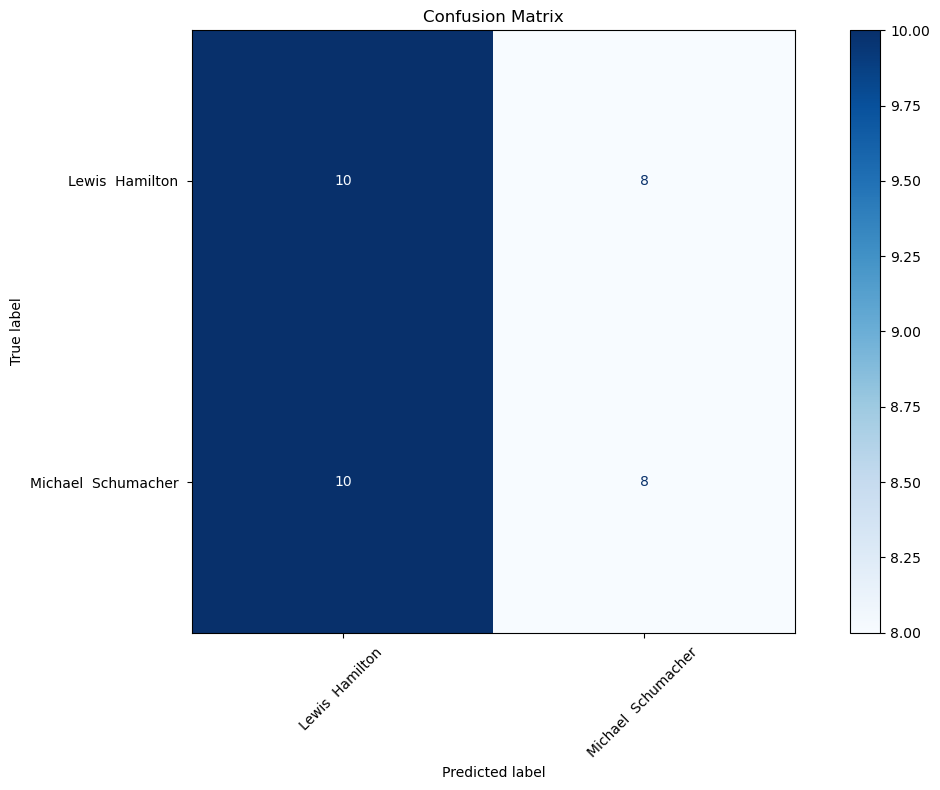

前10筆預測 vs. 真實：
Predicted Winner: Lewis  Hamilton , True Winner: Lewis  Hamilton 
Predicted Winner: Lewis  Hamilton , True Winner: Michael  Schumacher 
Predicted Winner: Michael  Schumacher , True Winner: Lewis  Hamilton 
Predicted Winner: Michael  Schumacher , True Winner: Lewis  Hamilton 
Predicted Winner: Lewis  Hamilton , True Winner: Lewis  Hamilton 
Predicted Winner: Michael  Schumacher , True Winner: Lewis  Hamilton 
Predicted Winner: Michael  Schumacher , True Winner: Lewis  Hamilton 
Predicted Winner: Michael  Schumacher , True Winner: Michael  Schumacher 
Predicted Winner: Michael  Schumacher , True Winner: Michael  Schumacher 
Predicted Winner: Lewis  Hamilton , True Winner: Michael  Schumacher 


In [15]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === 1. 讀取資料 ===
winners = pd.read_csv('./data/winners.csv')
drivers = pd.read_csv('./data/drivers_updated.csv')
laps = pd.read_csv('./data/fastest_laps_updated.csv')
teams = pd.read_csv('./data/teams_updated.csv')

# === 2. 欄位整理與年份解析 ===
winners['year'] = pd.to_datetime(winners['Date']).dt.year

# === 3. 合併資料 ===
df = winners.merge(
    drivers,
    left_on=['Winner', 'Car', 'year'],
    right_on=['Driver', 'Car', 'year'],
    how='left',
    suffixes=('', '_driver')
)
df = df.merge(
    laps,
    left_on=['Grand Prix', 'Winner', 'Car', 'year'],
    right_on=['Grand Prix', 'Driver', 'Car', 'year'],
    how='left',
    suffixes=('', '_lap')
)
df = df.merge(
    teams,
    left_on=['Car', 'year'],
    right_on=['Team', 'year'],
    how='left',
    suffixes=('', '_team')
)

# === 4. 篩選資料較完整且平衡的部分 ===
# 設定每位車手至少 K 場，且取所有達到標準的車手
K = 60
win_counts = df['Winner'].value_counts()
valid_winners = win_counts[win_counts >= K].index
df_balanced = df[df['Winner'].isin(valid_winners)].reset_index(drop=True)

# 平衡每位車手樣本數（下採樣到 min_n）
min_n = df_balanced['Winner'].value_counts().min()
dfs = []
for w in valid_winners:
    group = df_balanced[df_balanced['Winner'] == w]
    group_balanced = resample(group, replace=False, n_samples=min_n, random_state=42)
    dfs.append(group_balanced)
df_balanced = pd.concat(dfs).sample(frac=1, random_state=42).reset_index(drop=True)

# === 5. Label Encoding 與特徵工程 ===
le_winner = LabelEncoder()
le_car = LabelEncoder()
le_gp = LabelEncoder()
le_team = LabelEncoder()

df_balanced['winner_enc'] = le_winner.fit_transform(df_balanced['Winner'])
df_balanced['car_enc'] = le_car.fit_transform(df_balanced['Car'].astype(str))
df_balanced['gp_enc'] = le_gp.fit_transform(df_balanced['Grand Prix'].astype(str))
if 'Team' in df_balanced:
    df_balanced['team_enc'] = le_team.fit_transform(df_balanced['Team'].astype(str))

def lap_time_to_seconds(x):
    try:
        if pd.isnull(x):
            return 0.0
        if isinstance(x, float) or isinstance(x, int):
            return float(x)
        m, s = str(x).split(':')
        return float(m)*60 + float(s)
    except:
        return 0.0
df_balanced['fastestLapTime_sec'] = df_balanced['Time'].apply(lap_time_to_seconds) if 'Time' in df_balanced else 0.0
df_balanced['Laps'] = pd.to_numeric(df_balanced['Laps'], errors='coerce').fillna(0)
df_balanced['PTS'] = pd.to_numeric(df_balanced['PTS'], errors='coerce').fillna(0)

feature_cols = ['car_enc', 'gp_enc', 'year', 'Laps', 'PTS', 'fastestLapTime_sec']
if 'team_enc' in df_balanced: feature_cols.append('team_enc')
X = df_balanced[feature_cols].fillna(0).values
y = df_balanced['winner_enc'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

# === 6. 製作 LSTM 時序資料 ===
def create_sequences(X, y, time_steps=5):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 5
X_seq, y_seq = create_sequences(X, y, time_steps)
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq)

# === 7. LSTM Model 定義 ===
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2
num_classes = len(np.unique(y))
model = LSTMModel(input_size, hidden_size, num_layers, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_torch = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_torch = torch.tensor(y_test, dtype=torch.long).to(device)

# === 8. 訓練迴圈 ===
num_epochs = 3000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_torch)
        _, predicted = torch.max(test_outputs, 1)
        acc = (predicted == y_test_torch).float().mean()
    if (epoch+1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Acc: {acc:.4f}")

# === 9. 預測、Top-k 評估、混淆矩陣 ===
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_torch)
    _, predicted = torch.max(test_outputs, 1)
    pred_labels = predicted.cpu().numpy()
    true_labels = y_test
    # Top-k 準確率
    for k in [1, 2]:
        topk = torch.topk(test_outputs, k, dim=1).indices.cpu().numpy()
        hits = sum([true_labels[i] in topk[i] for i in range(len(true_labels))])
        print(f"Top-{k} accuracy: {hits/len(true_labels):.3f}")

    # 混淆矩陣
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_winner.inverse_transform(np.arange(num_classes)))
    fig, ax = plt.subplots(figsize=(12, 8))
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # 預測 vs. 真實 前 10 筆
    pred_driver = le_winner.inverse_transform(pred_labels)
    true_driver = le_winner.inverse_transform(true_labels)
    print("前10筆預測 vs. 真實：")
    for i in range(10):
        print(f"Predicted Winner: {pred_driver[i]}, True Winner: {true_driver[i]}")


c:\Users\lu050\anaconda3\envs\pytorch\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:05:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.8000
                         precision    recall  f1-score   support

          Alain  Prost        0.91      1.00      0.95        10
            Alan Jones        0.67      1.00      0.80         2
       Alberto  Ascari        1.00      1.00      1.00         3
         Ayrton  Senna        1.00      1.00      1.00         8
        Bruce  McLaren        0.00      0.00      0.00         1
     Carlos  Reutemann        0.50      0.50      0.50         2
         Carlos  Sainz        1.00      1.00      1.00         1
      Charles  Leclerc        1.00      1.00      1.00         1
       Clay  Regazzoni        0.00      0.00      0.00         1
           Damon  Hill        0.50      1.00      0.67         4
           Dan  Gurney        0.00      0.00      0.00         1
     Daniel  Ricciardo        0.50      1.00      0.67         2
      David  Coulthard        0.33      0.33      0.33         3
          Denny  Hulme        0.00      0.00      0.00         2
       

c:\Users\lu050\anaconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lu050\anaconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lu050\anaconda3\envs\pytorch\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


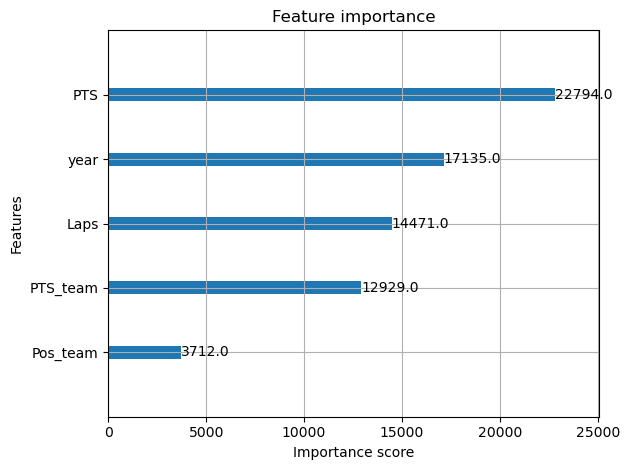

前10筆預測 vs. 真實：
1967 0.0
Predicted Winner: Jim  Clark  , True Winner: Jim  Clark 

1980 0.0
Predicted Winner: Rene  Arnoux  , True Winner: Rene  Arnoux 

1996 0.0
Predicted Winner: Jacques  Villeneuve  , True Winner: Jacques  Villeneuve 

2013 0.0
Predicted Winner: Nico  Rosberg  , True Winner: Nico  Rosberg 

1990 0.0
Predicted Winner: Alain  Prost  , True Winner: Alain  Prost 

2020 0.0
Predicted Winner: Daniel  Ricciardo  , True Winner: Max  Verstappen 

1991 0.0
Predicted Winner: Nigel  Mansell  , True Winner: Nigel  Mansell 

2018 0.0
Predicted Winner: Daniel  Ricciardo  , True Winner: Daniel  Ricciardo 

1953 0.0
Predicted Winner: Alberto  Ascari  , True Winner: Alberto  Ascari 

2009 0.0
Predicted Winner: Jenson  Button  , True Winner: Jenson  Button 

1995 0.0
Predicted Winner: Michael  Schumacher  , True Winner: Michael  Schumacher 

1990 0.0
Predicted Winner: Alain  Prost  , True Winner: Alain  Prost 

1988 0.0
Predicted Winner: Ayrton  Senna  , True Winner: Ayrton  Senna 

20

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt

# 1. 讀取資料
winners = pd.read_csv('./data/winners.csv')
drivers = pd.read_csv('./data/drivers_updated.csv')
laps = pd.read_csv('./data/fastest_laps_updated.csv')
teams = pd.read_csv('./data/teams_updated.csv')

# 2. 欄位整理
winners['year'] = pd.to_datetime(winners['Date']).dt.year

# 3. 合併資料
df = winners.merge(
    drivers,
    left_on=['Winner', 'Car', 'year'],
    right_on=['Driver', 'Car', 'year'],
    how='left',
    suffixes=('', '_driver')
)
df = df.merge(
    laps,
    left_on=['Grand Prix', 'Winner', 'Car', 'year'],
    right_on=['Grand Prix', 'Driver', 'Car', 'year'],
    how='left',
    suffixes=('', '_lap')
)
df = df.merge(
    teams,
    left_on=['Car', 'year'],
    right_on=['Team', 'year'],
    how='left',
    suffixes=('', '_team')
)

# 4. 特徵欄位設定
features = [
    'year',
    'Grand Prix',
    'Car',
    'Laps',
    'Time',
    'Nationality',
    'PTS',
    'Time_lap',
    'PTS_team',
    'Pos_team'
]

# 5. 填補缺失值
df['PTS_team'] = df['PTS_team'].fillna(0)
df['Time_lap'] = df['Time_lap'].fillna('0')
df['Pos_team'] = df['Pos_team'].fillna(0)

# 6. 確保所有特徵欄位型態為 int/float
for col in features:
    try:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    except:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    if df[col].dtype == 'object':
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# 7. 過濾只拿過一次冠軍的車手
vc = df['Winner'].value_counts()
multi_winners = vc[vc > 1].index
df_filtered = df[df['Winner'].isin(multi_winners)].copy()

# 8. 資料分 X, y
X = df_filtered[features]
y = df_filtered['Winner']
le_winner = LabelEncoder()
y_encoded = le_winner.fit_transform(y)

# 9. train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 10. 訓練 XGBoost 分類器
model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    objective='multi:softmax',
    num_class=len(le_winner.classes_),
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
model.fit(X_train, y_train)

# 11. 預測與評估
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

from sklearn.utils.multiclass import unique_labels
labels_in_test = unique_labels(y_test, y_pred)
target_names = le_winner.inverse_transform(labels_in_test)
print(classification_report(y_test, y_pred, labels=labels_in_test, target_names=target_names))

# 12. 特徵重要性可視化
xgb.plot_importance(model)
plt.tight_layout()
plt.show()

# 13. 前10筆預測 vs. 真實（含比賽資訊）
pred_names = le_winner.inverse_transform(y_pred)
true_names = le_winner.inverse_transform(y_test)
orig_idx = X_test.index
race_info = df_filtered.loc[orig_idx, ['year', 'Grand Prix']].reset_index(drop=True)
compare_df = pd.DataFrame({
    'year': race_info['year'],
    'Grand Prix': race_info['Grand Prix'],
    'Predicted Winner': pred_names,
    'True Winner': true_names
})
print("前20筆預測 vs. 真實：")
for i, row in compare_df.head(20).iterrows():
    print(f"{row['year']} {row['Grand Prix']}\nPredicted Winner: {row['Predicted Winner']} , True Winner: {row['True Winner']}\n")

